# Main

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import seaborn as sns

In [3]:
# processed db includes datetime and data is converted to numeric
db_file_path = "../data/can_data_processed_23112023.db"
conn = sqlite3.connect(db_file_path)

In [4]:
# plot consistency
sns.set_style("whitegrid")
sns.set_palette("pastel")
pd.set_option("float_format", "{:f}".format)
common_figsize = (14, 8)

In [5]:
# read data
query = "SELECT * FROM ProcessedCANData"
df = pd.read_sql_query(query, conn)
conn.close()

In [6]:
df.columns

Index(['DrBack_Press', 'Supply_Press', 'Oil_Temp', 'Cool_Temp',
       'Steering_Angle', 'Amb_Temp', 'FuelPressure', 'Cab_Angle', 'Drive_Dir',
       'timestamp', 'WorkPump_Press', 'file', 'ChargedAir_Press',
       'RetFilt_Press', 'CraneSwivel_Angle', 'HeadPump_Angle', 'DrFor_Press',
       'Engine_Load', 'Bat_Volt', 'Oil_Press', 'Speed', 'FrameFB_Angle',
       'FrameLR_Angle', 'RPM_DriveMot', 'WorkPump_Q', 'RPM_Diesel',
       'datetime'],
      dtype='object')

In [16]:
data = df[["FuelPressure", "Engine_Load", "RPM_Diesel"]]  # , 'datetime', 'timestamp']]

# Descriptive Statistics

In [17]:
descriptive_stats = data.describe()
skewness = data.skew().rename("skewness")
kurtosis = data.kurtosis().rename("kurtosis")

all_stats = pd.concat([descriptive_stats.T, skewness, kurtosis], axis=1)

In [18]:
all_stats.T

,FuelPressure,Engine_Load,RPM_Diesel
count,2238512.000000,2238512.000000,2230676.000000
mean,2.162718,10.664446,484.030519
std,2.287662,12.251977,556.114354
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,4.400000,21.000000,800.000000
max,5.160000,125.000000,1838.000000
skewness,0.123955,0.815612,0.614845
kurtosis,-1.961738,0.610495,-1.016291


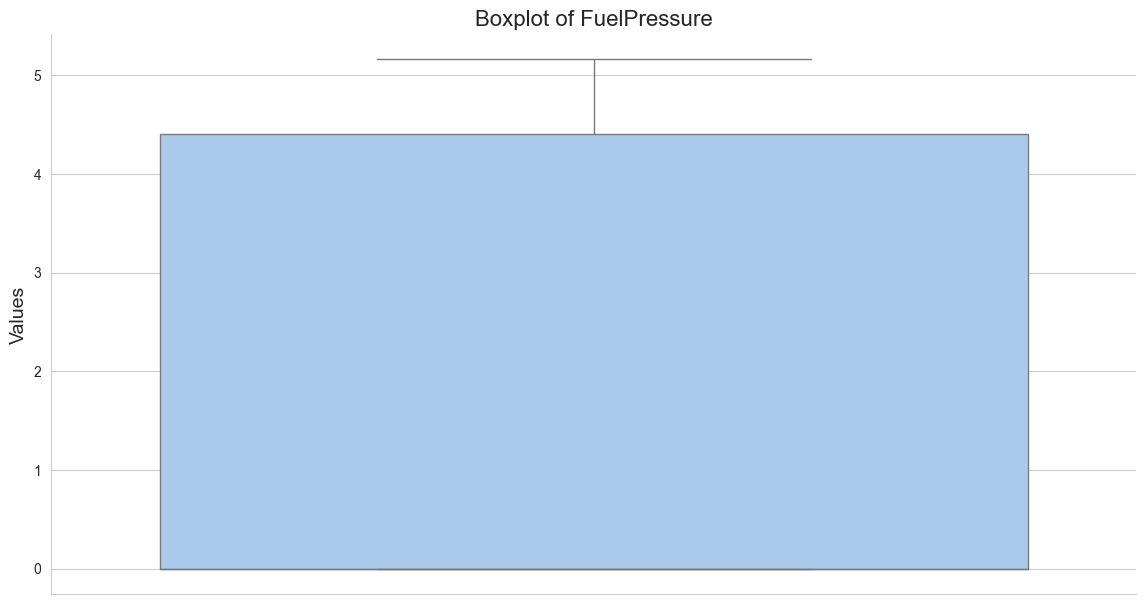

In [19]:
plt.figure(figsize=common_figsize)
sns.boxplot(data=data["FuelPressure"])
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Values", fontsize=14)
plt.title("Boxplot of FuelPressure", fontsize=16)
plt.subplots_adjust(bottom=0.2, top=0.9)
sns.despine()
plt.show()

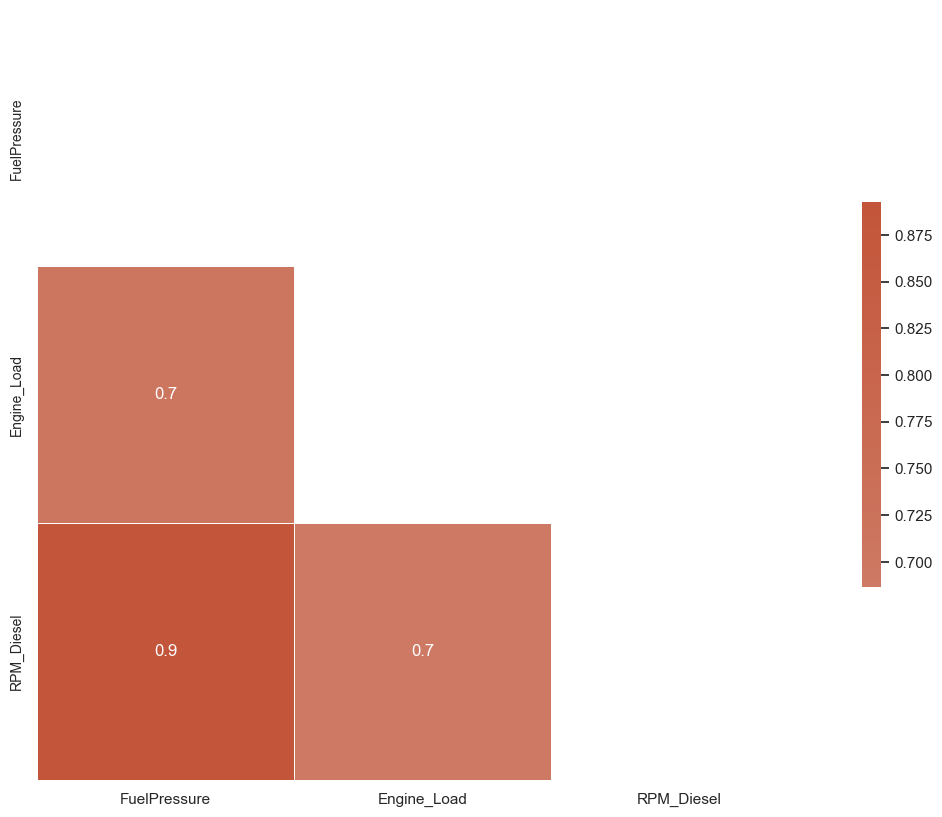

In [20]:
correlation_matrix = data.corr(method="kendall")
plt.figure(figsize=(14, 10))
sns.set(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    fmt=".1f",
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

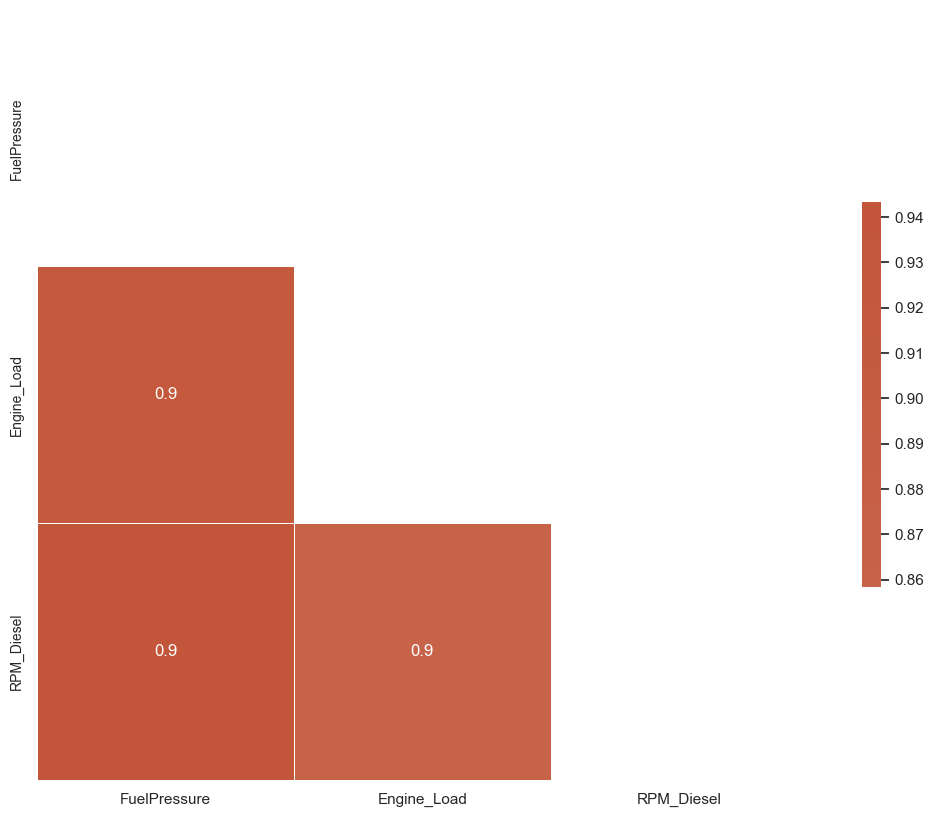

In [55]:
correlation_matrix = data.corr(method="pearson")
plt.figure(figsize=(14, 10))
sns.set(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    fmt=".1f",
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [70]:
print(pd.unique(df["FuelPressure"]))
print(len(pd.unique(df["FuelPressure"])))

[0.    nan 5.   4.96 5.04 4.88 4.68 4.52 4.44 4.48 4.6  4.76 4.72 4.8
 4.84 4.64 4.92 5.12 5.16 5.08 4.32 3.88 2.2  1.04 0.56 0.36 0.28 0.2
 0.16 0.12 0.08 0.04 2.68 4.04 4.4  4.36 4.56 4.08 2.64 1.24 0.6  0.24
 0.48 2.52 4.24 3.96 0.92 0.44 2.12 3.84 4.28 1.76 0.64 0.32 2.76 4.
 0.72 3.08 4.12 4.2  2.28 0.4 ]
62


# Data Distribution

In [10]:
def freedman_diaconis_bins(data):
    data = data.astype(float)
    if len(data) > 1 and data.nunique() > 1:
        quartile_range = np.percentile(data, 75) - np.percentile(data, 25)
        if quartile_range == 0:
            return 1
        bin_width = 2 * quartile_range * (len(data) ** (-1 / 3))
        num_bins = (data.max() - data.min()) / bin_width
        return max(1, round(num_bins))
    else:
        return 1


def remove_outliers(df, column, multiplier=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:  # Handle case where all data points are the same
        return df
    lower_bound = q1 - (multiplier * iqr)
    upper_bound = q3 + (multiplier * iqr)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

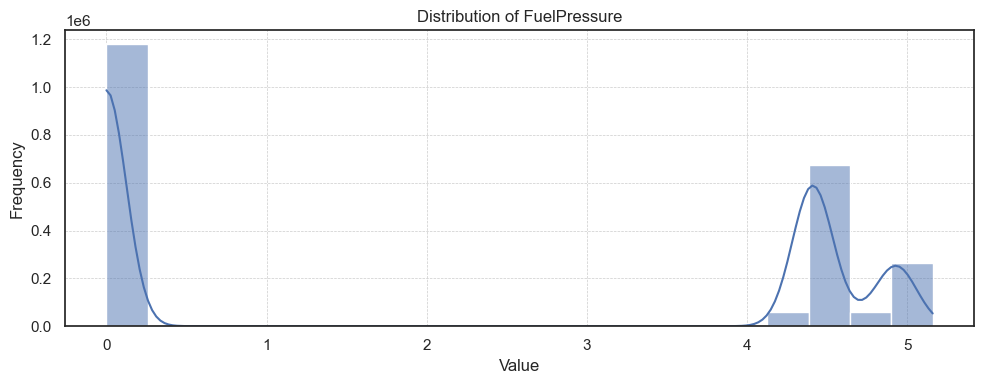

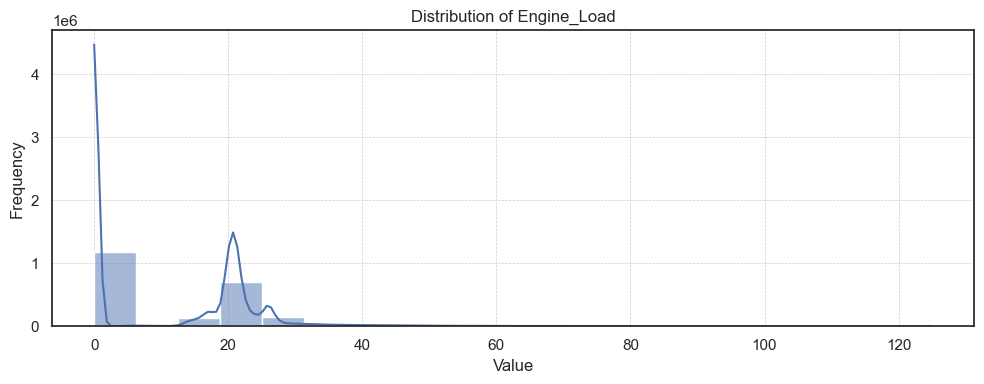

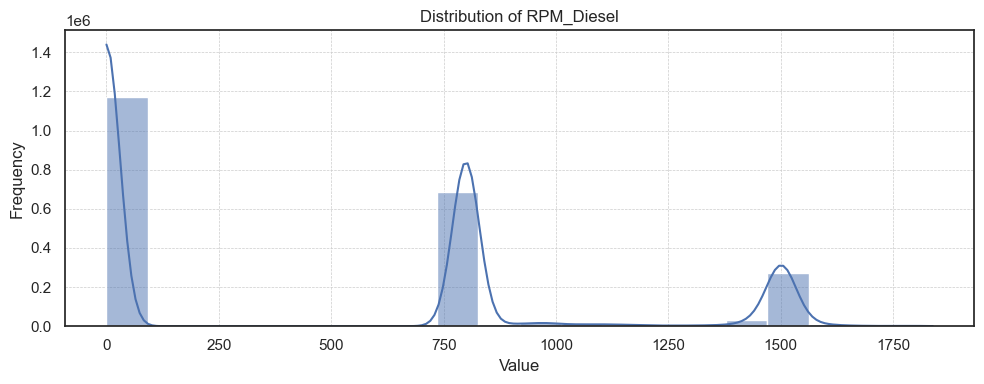

In [23]:
for column in data.columns:
    if data[column].isna().all():
        continue

    column_data = data[column].dropna()
    bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)
    sns.histplot(column_data, bins=20, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [24]:
df_clean = data.copy()

for column in data.columns:
    if data[column].dtype in ["float64", "int64"] and data[column].nunique() > 1:
        df_clean = remove_outliers(df_clean, column)

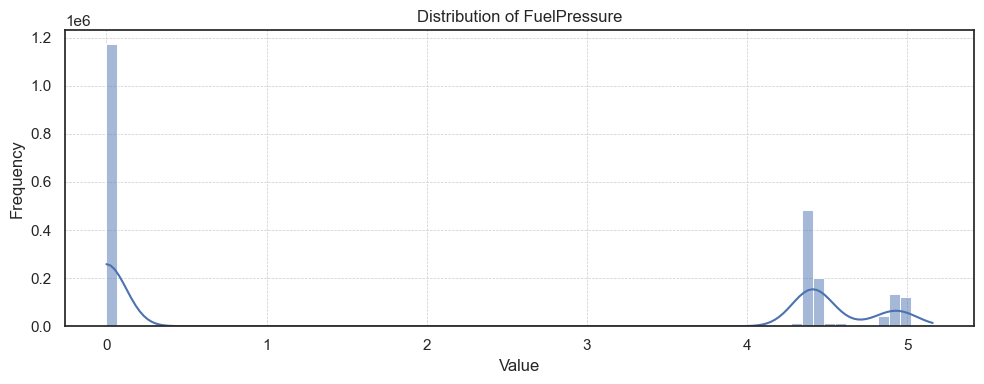

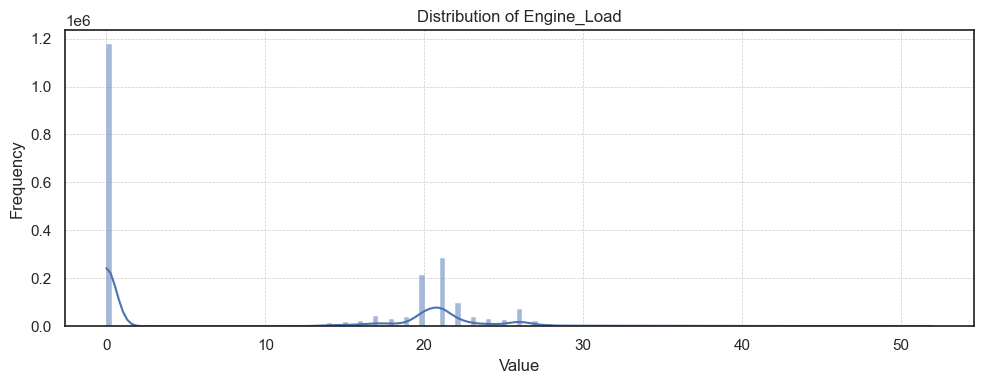

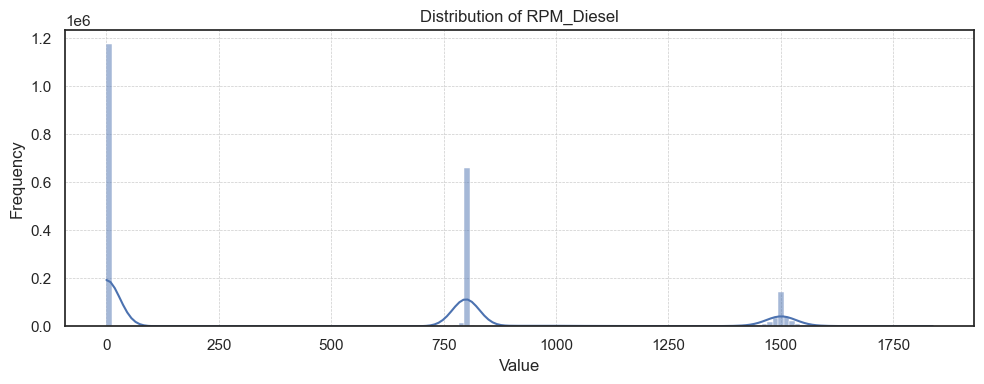

In [25]:
for column in df_clean.columns:
    if df_clean[column].isna().all() or df_clean[column].nunique() == 1:
        continue
    try:
        column_data = pd.to_numeric(df_clean[column].dropna(), errors="coerce")
        bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1
    except ValueError:
        continue

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)

    if column_data.nunique() != 1:
        sns.histplot(column_data, bins=bins, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    plt.show()

<Axes: xlabel='FuelPressure', ylabel='RPM_Diesel'>

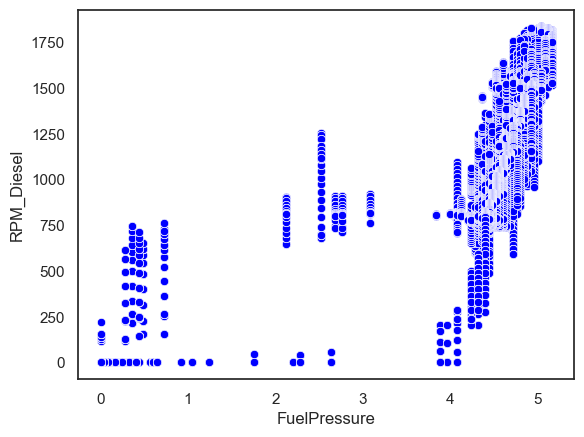

In [26]:
sns.scatterplot(x="FuelPressure", y="RPM_Diesel", data=df, color="blue")

<Axes: xlabel='FuelPressure', ylabel='Engine_Load'>

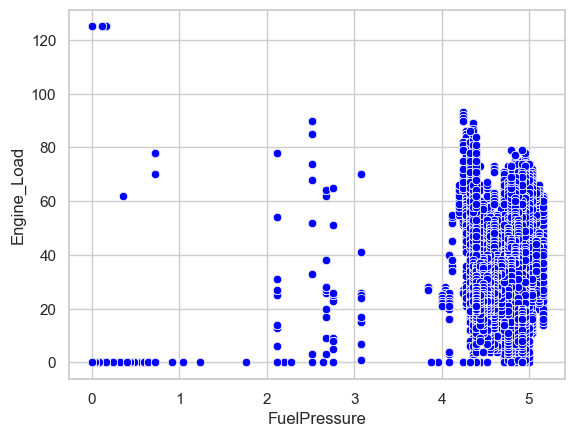

In [54]:
sns.scatterplot(x="FuelPressure", y="Engine_Load", data=df, color="blue")

# External Data Analysis

## Main 

In [7]:
df_ext = pd.read_csv("../data/external_data/engine_data.csv", index_col=None)
df_ext = df_ext.rename(
    columns={"Fuel pressure": "FuelPressure", "Engine rpm": "RPM_Diesel"}
)
df_ext.head()

,RPM_Diesel,Lub oil pressure,FuelPressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


## External Data Descriptive Statistics

In [28]:
descriptive_stats_ext = df_ext.describe()
skewness_ext = df_ext.skew().rename("skewness")
kurtosis_ext = df_ext.kurtosis().rename("kurtosis")

all_stats_ext = pd.concat([descriptive_stats_ext.T, skewness_ext, kurtosis_ext], axis=1)

<Axes: >

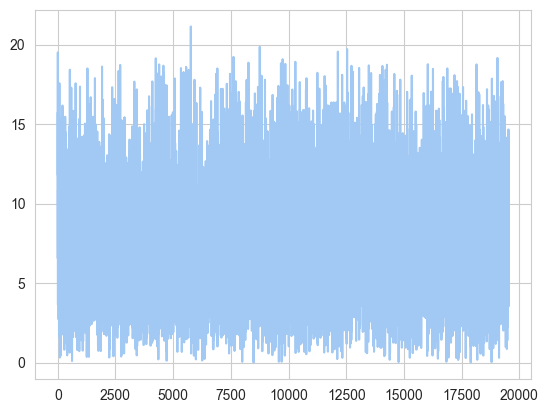

In [34]:
df_ext["FuelPressure"].plot()

In [29]:
all_stats_ext.T

,RPM_Diesel,Lub oil pressure,FuelPressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000
skewness,0.934932,0.195783,1.216387,1.309420,1.496375,0.404451,-0.540826
kurtosis,0.936921,-0.260152,2.452666,2.556044,1.749363,5.880549,-1.707682


In [65]:
correlation_matrix_ext_kendall = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="kendall"
)
correlation_matrix_ext_spearman = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="spearman"
)
correlation_matrix_ext_pearson = df_ext[["FuelPressure", "RPM_Diesel"]].corr(
    method="pearson"
)

In [66]:
correlation_matrix_ext_pearson

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.001571
RPM_Diesel,-0.001571,1.000000


In [67]:
correlation_matrix_ext_kendall

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.004791
RPM_Diesel,-0.004791,1.000000


In [68]:
correlation_matrix_ext_spearman

,FuelPressure,RPM_Diesel
FuelPressure,1.000000,-0.007113
RPM_Diesel,-0.007113,1.000000


In [71]:
print(pd.unique(df_ext["FuelPressure"]))
print(len(pd.unique(df_ext["FuelPressure"])))

[11.79092738 16.19386556  6.55314691 ...  4.92737579  8.29181555
  3.96248044]
19531


## External Data Distribution

In [8]:
from scipy.stats import norm, expon

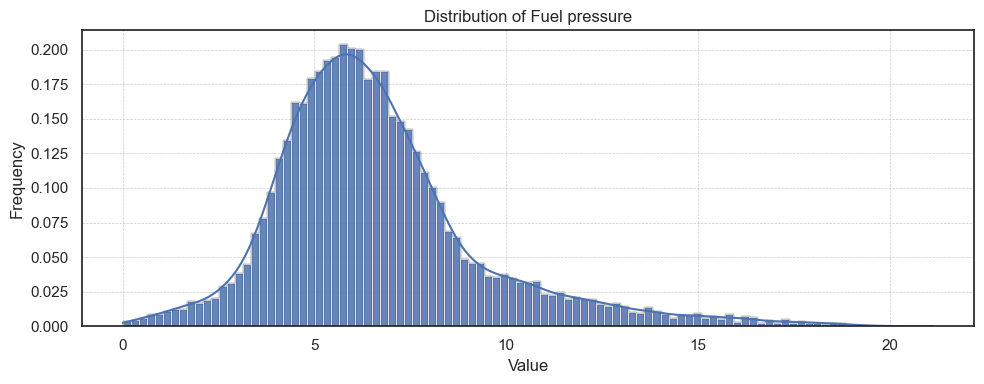

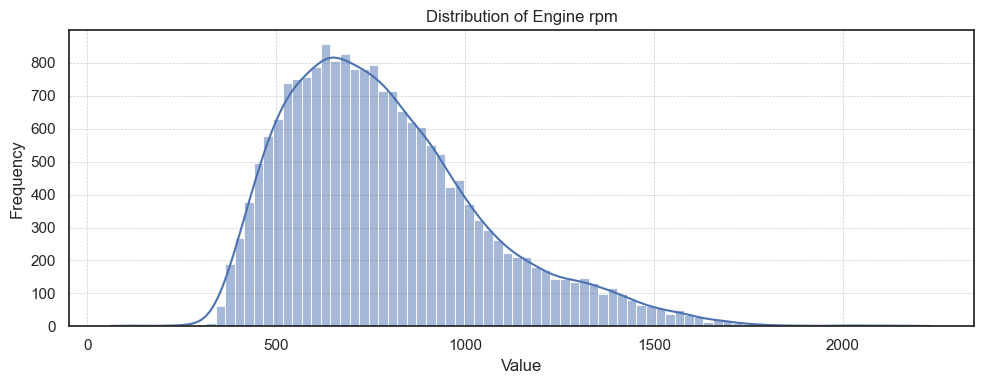

In [31]:
bins = freedman_diaconis_bins(df_ext["FuelPressure"])

plt.figure(figsize=(10, 4))
plt.hist(df_ext["FuelPressure"], bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(df_ext["FuelPressure"], stat="density", bins=bins, kde=True)

plt.title("Distribution of Fuel pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

bins = freedman_diaconis_bins(df_ext["RPM_Diesel"])

plt.figure(figsize=(10, 4))
plt.hist(df_ext["RPM_Diesel"], bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(df_ext["RPM_Diesel"], bins=bins, kde=True)

plt.title("Distribution of Engine rpm")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [32]:
df_ext_cleaned = df_ext[["RPM_Diesel", "FuelPressure"]].copy()

for column in df_ext_cleaned.columns:
    if (
        df_ext_cleaned[column].dtype in ["float64", "int64"]
        and df_ext_cleaned[column].nunique() > 1
    ):
        df_ext_cleaned = remove_outliers(df_ext_cleaned, column)

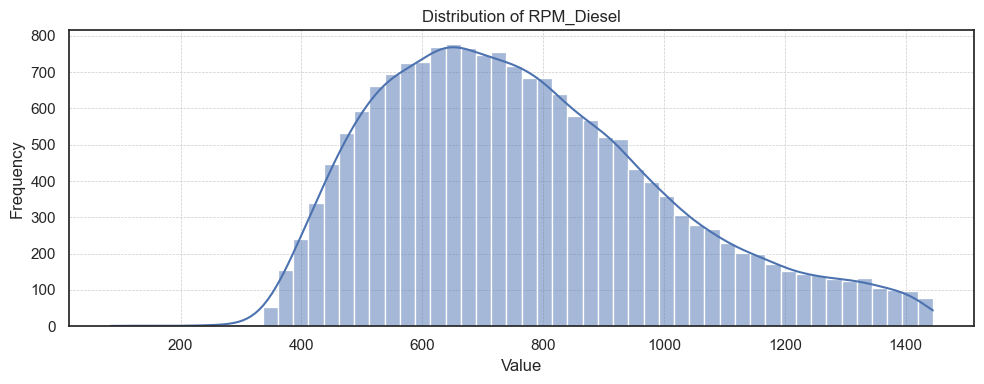

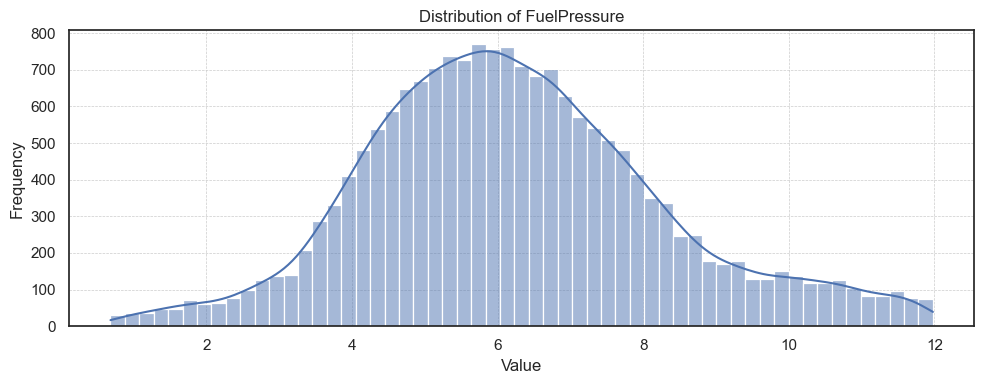

In [33]:
for column in df_ext_cleaned.columns:
    if df_ext_cleaned[column].isna().all() or df_ext_cleaned[column].nunique() == 1:
        continue
    try:
        column_data = pd.to_numeric(df_ext_cleaned[column].dropna(), errors="coerce")
        bins = freedman_diaconis_bins(column_data) if len(column_data) > 1 else 1
    except ValueError:
        continue

    plt.figure(figsize=(10, 4))
    plt.hist(column_data, bins=bins, edgecolor="black", alpha=0.7, density=True)

    if column_data.nunique() != 1:
        sns.histplot(column_data, bins=bins, kde=True)

    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    plt.show()

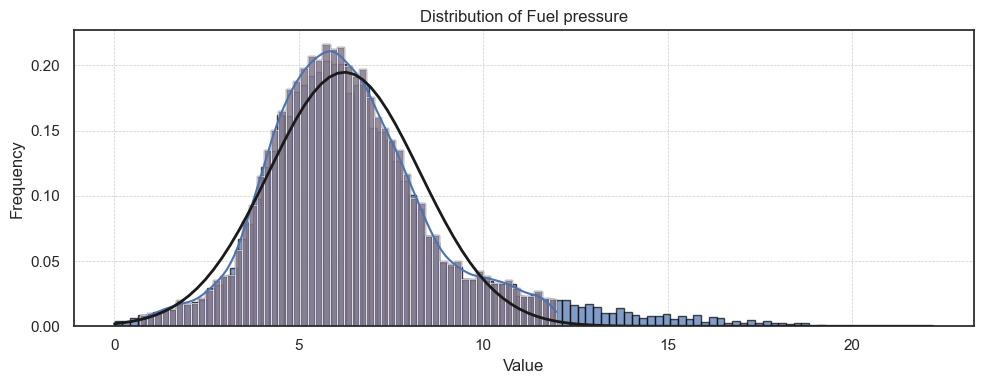

In [106]:
data_to_plot = df_ext_cleaned["FuelPressure"]
plt.figure(figsize=(10, 4))

# data
bins = freedman_diaconis_bins(df_ext["FuelPressure"])
plt.hist(df_ext["FuelPressure"], bins=bins, edgecolor="black", alpha=0.7, density=True)
# sns.histplot(df_ext["FuelPressure"], stat='density', bins=bins, kde=True)

# cleaned data
bins_clean = freedman_diaconis_bins(data_to_plot)
plt.hist(data_to_plot, bins=bins_clean, edgecolor="black", alpha=0.7, density=True)
sns.histplot(data_to_plot, stat="density", bins=bins_clean, kde=True)

# normal distribution
mu, std = norm.fit(data_to_plot)
# mu = mu - 0.4
# std = std - 0.1
xmin, xmax = plt.xlim()
x = np.linspace(0, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)

plt.title("Distribution of Fuel pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

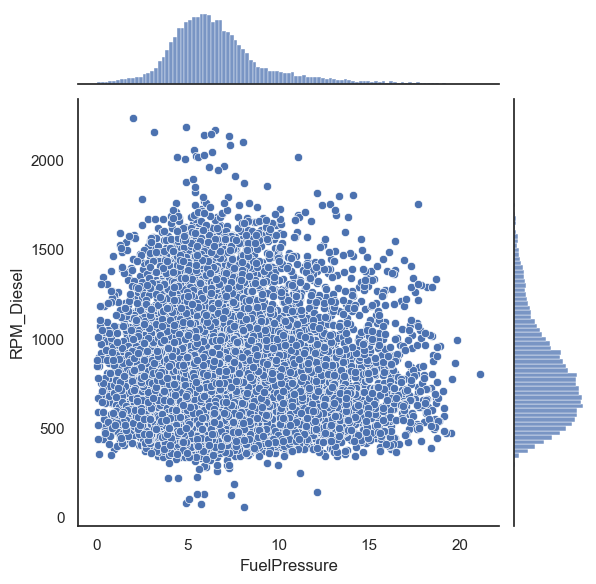

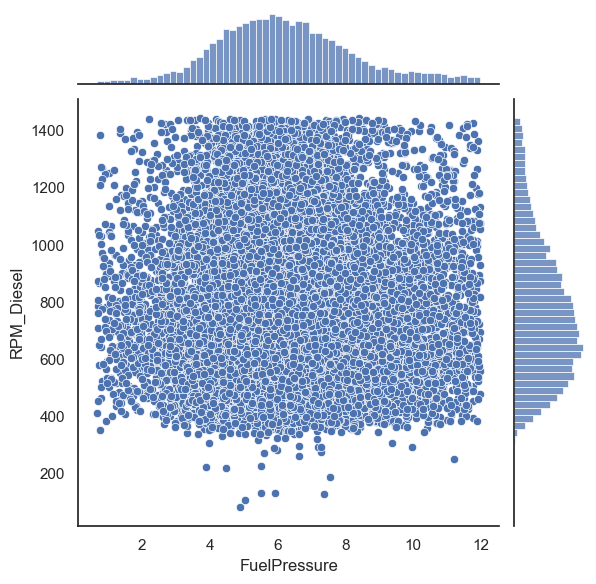

In [36]:
sns.jointplot(df_ext, x="FuelPressure", y="RPM_Diesel")
sns.jointplot(df_ext_cleaned, x="FuelPressure", y="RPM_Diesel")

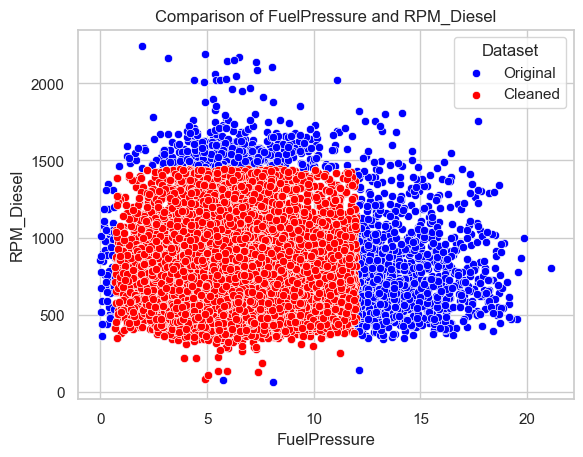

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots()

sns.scatterplot(
    x="FuelPressure", y="RPM_Diesel", data=df_ext, ax=ax, color="blue", label="Original"
)

sns.scatterplot(
    x="FuelPressure",
    y="RPM_Diesel",
    data=df_ext_cleaned,
    ax=ax,
    color="red",
    label="Cleaned",
)

ax.legend(title="Dataset")
ax.set_xlabel("FuelPressure")
ax.set_ylabel("RPM_Diesel")
ax.set_title("Comparison of FuelPressure and RPM_Diesel")

plt.show()

# Concatenated Data Distribution

In [44]:
df_int = pd.concat(
    [df_ext[["FuelPressure", "RPM_Diesel"]], df[["FuelPressure", "RPM_Diesel"]]], axis=0
)

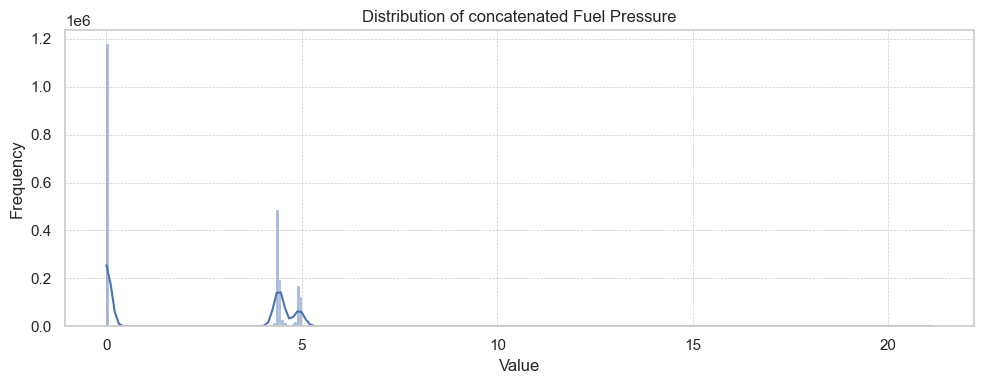

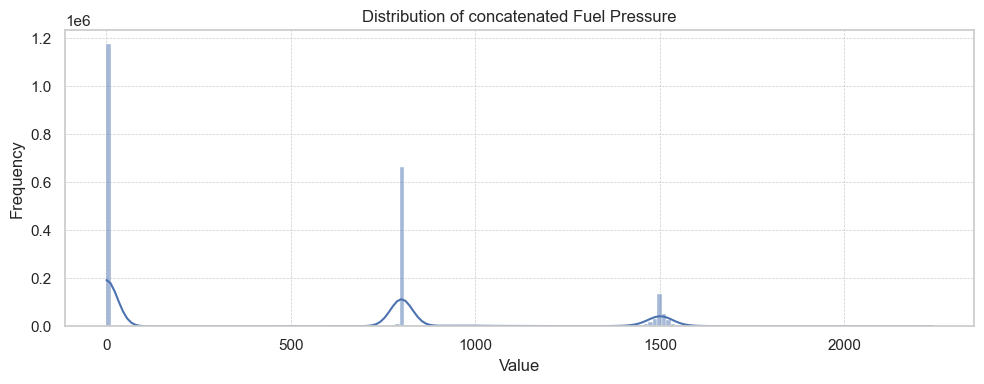

In [53]:
for column in df_int.columns:
    data_to_plot = df_int[column].dropna()
    bins = freedman_diaconis_bins(data_to_plot)

    plt.figure(figsize=(10, 4))
    plt.hist(data_to_plot, bins=bins, edgecolor="black", alpha=0.7, density=True)
    sns.histplot(data_to_plot, bins=bins, kde=True)

    plt.title("Distribution of concatenated Fuel Pressure")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [72]:
df_ext_upsampled = df_ext.copy()

while len(df_ext_upsampled) < len(df):
    df_ext_upsampled = pd.concat([df_ext_upsampled, df_ext], ignore_index=True)

df_concatenated = pd.concat([df_ext_upsampled, df], axis=0).reset_index(drop=True)

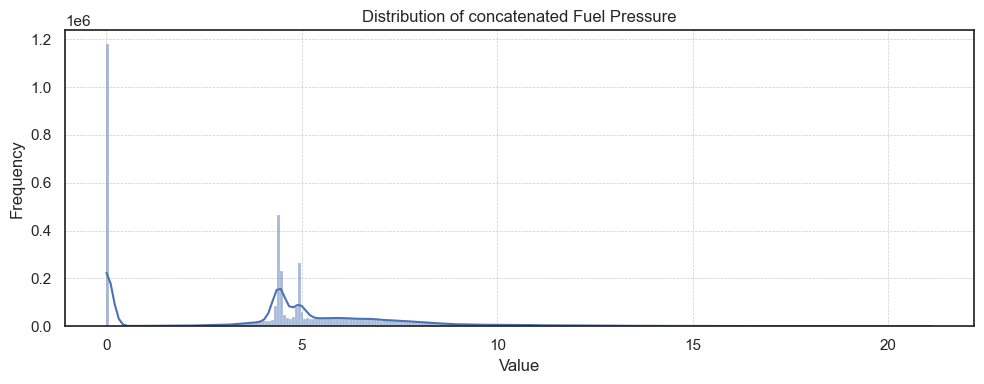

In [73]:
data_to_plot = df_concatenated["FuelPressure"].dropna()
bins = freedman_diaconis_bins(data_to_plot)

plt.figure(figsize=(10, 4))
plt.hist(data_to_plot, bins=bins, edgecolor="black", alpha=0.7, density=True)
sns.histplot(data_to_plot, bins=bins, kde=True)

plt.title("Distribution of concatenated Fuel Pressure")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [105]:
print(pd.unique(df_ext["FuelPressure"]))
print(pd.unique(df["FuelPressure"]))

[11.79092738 16.19386556  6.55314691 ...  4.92737579  8.29181555
  3.96248044]
[0.    nan 5.   4.96 5.04 4.88 4.68 4.52 4.44 4.48 4.6  4.76 4.72 4.8
 4.84 4.64 4.92 5.12 5.16 5.08 4.32 3.88 2.2  1.04 0.56 0.36 0.28 0.2
 0.16 0.12 0.08 0.04 2.68 4.04 4.4  4.36 4.56 4.08 2.64 1.24 0.6  0.24
 0.48 2.52 4.24 3.96 0.92 0.44 2.12 3.84 4.28 1.76 0.64 0.32 2.76 4.
 0.72 3.08 4.12 4.2  2.28 0.4 ]


In [104]:
np.sum(
    [
        element in pd.unique(df_ext["FuelPressure"])
        for element in pd.unique(df["FuelPressure"])
    ]
)

0

# Final Data 

## Data Concatetion

In [79]:
diesel_filter_data = pd.Series(np.concatenate((df_ext["FuelPressure"], pd.unique(df["FuelPressure"].dropna()))))

## Data Fitting

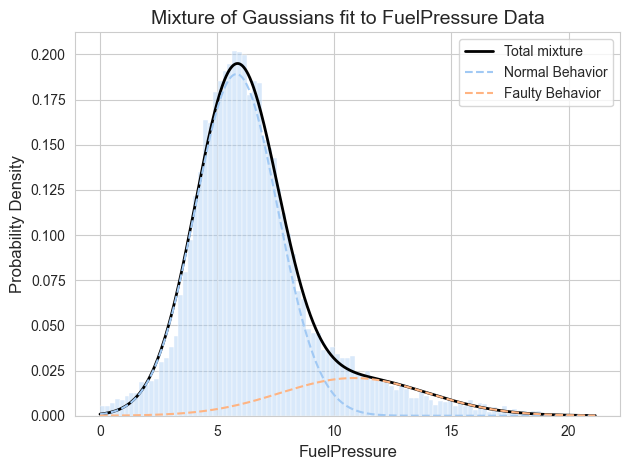

In [80]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import stats

data = diesel_filter_data.values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=40)
gmm.fit(data)
x = np.linspace(data.min(), data.max(), 2000).reshape(-1, 1)
pdf_individual = [
    gmm.weights_[i]
    * stats.norm(gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0])).pdf(x).flatten()
    for i in range(gmm.n_components)
]
pdf_total = np.sum(pdf_individual, axis=0)

sns.histplot(
    data,
    bins=freedman_diaconis_bins(diesel_filter_data),
    kde=False,
    stat="density",
    color="grey",
    alpha=0.4,
)
plt.plot(x, pdf_total, color="black", lw=2, label="Total mixture")

plt.plot(x, pdf_individual[0], "--", lw=1.5, label=f"Normal Behavior")
plt.plot(x, pdf_individual[1], "--", lw=1.5, label=f"Faulty Behavior")

plt.xlabel("FuelPressure", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.title("Mixture of Gaussians fit to FuelPressure Data", fontsize=14)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [64]:
print(gmm.weights_)

[0.83572461 0.16427539]


In [109]:
print(gmm.means_)

[[ 5.8327516 ]
 [10.85936137]]


In [110]:
print(gmm.covariances_)

[[[3.07356638]]

 [[9.73305603]]]


In [111]:
print(gmm.n_components)

2


## Autocorrelation

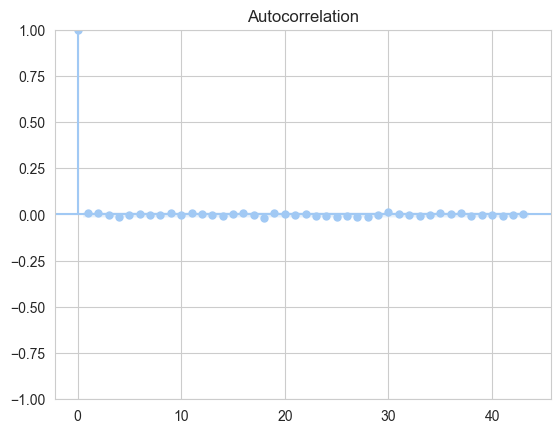

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diesel_filter_data, alpha=0.05)
plt.show()

c:\Python311\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Python311\Lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Python311\Lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_flo

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           FuelPressure   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -47547.2
Distribution:                  Normal   AIC:                           95102.4
Method:            Maximum Likelihood   BIC:                           95134.0
                                        No. Observations:                19535
Date:                Tue, Dec 12 2023   Df Residuals:                    19534
Time:                        12:24:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             6.6542  1.975e-02    336.968      0.000 [  6.615,  6.69

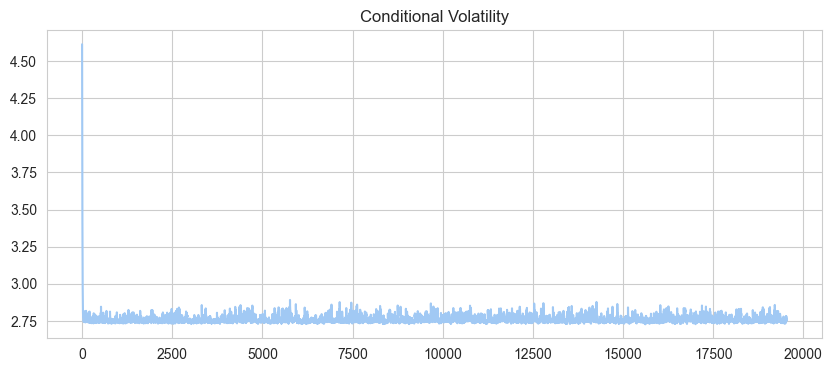

In [68]:
import numpy as np
from arch import arch_model

model = arch_model(diesel_filter_data, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

print(model_fit.summary())

conditional_volatility = model_fit.conditional_volatility

plt.figure(figsize=(10, 4))
plt.plot(conditional_volatility)
plt.title('Conditional Volatility')
plt.show()


# Data Sampling

## Ancestral Sampling

In [70]:
import numpy as np
from sklearn.mixture import GaussianMixture

# ancestral sampling
def sample_from_gmm(gmm, n_samples=1):
    components = np.random.choice(len(gmm.weights_), size=n_samples, p=gmm.weights_)
    print(components)
    samples = np.array(
        [
            np.random.multivariate_normal(
                mean=gmm.means_[component], cov=gmm.covariances_[component], size=1
            ).flatten()
            for component in components
        ]
    )
    print(samples)

    return samples


# n_samples = 100000
# samples = sample_from_gmm(gmm, n_samples=n_samples)

[0 1 0 ... 0 0 0]
[[ 8.76253699]
 [21.97305061]
 [ 6.74434184]
 ...
 [ 7.92836758]
 [ 8.74105845]
 [ 5.26776854]]


In [72]:
sample_from_gmm(gmm, n_samples=1)

[0]
[[7.80739787]]


array([[7.80739787]])

<Axes: ylabel='Density'>

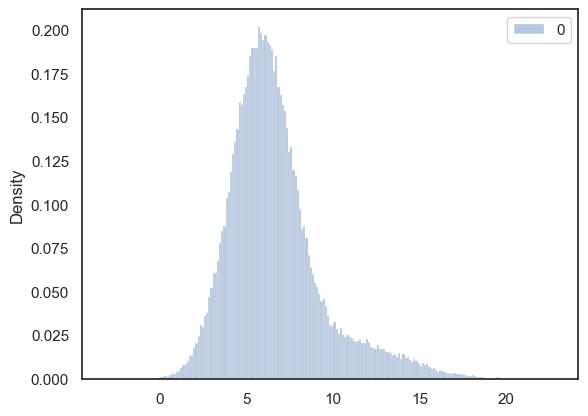

In [135]:
sns.histplot(
    samples,
    bins=freedman_diaconis_bins(pd.Series(samples.flatten())),
    kde=False,
    stat="density",
    color="grey",
    alpha=0.4,
)

## Box Muller Algorithm

In [51]:
def box_muller(n):
    u1 = np.random.uniform(size = n)
    u2 = np.random.uniform(size = n)
    r = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

n = 100000
samples_z0, samples_z1 = box_muller(n)

transformed_samples_z0 = (gmm.covariances_[0] * samples_z0 + gmm.means_[0]).flatten()
transformed_samples_z1 = (gmm.covariances_[1] * samples_z1 + gmm.means_[1]).flatten()

drawn_samples_z0 = np.random.choice(transformed_samples_z0, size=int(n*gmm.weights_[0]), replace=False)
drawn_samples_z1 = np.random.choice(transformed_samples_z1, size=int(n*gmm.weights_[1]), replace=False)

full_samples = np.concatenate((drawn_samples_z0, drawn_samples_z1)) 
